# Preparing data and building adjacency matrix

In [1]:
# Reading and preparing data
import numpy as np

interleaved_poses = np.load('./data/pose_extraction_video_1.npy')
poses_1 = interleaved_poses[0::2]
poses_2 = interleaved_poses[1::2]

joint_poses = np.concatenate((poses_1, poses_2), axis=1)
print('Joint poses shape: {}'.format(joint_poses.shape))

Joint poses shape: (297, 48, 3)


In [2]:
# Building initial adjacency matrix
adj_matrix = [[0, 1], [0, 2], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10],
              [8, 11], [9, 12], [9, 13], [9, 14], [12, 15], [13, 16], [14, 17], [16, 18], [17, 19], 
              [18, 20], [19, 21], [20, 22], [21, 23]]

# Getting second person skeleton
init_skeleton_len = len(adj_matrix)
for edge_index in range(init_skeleton_len):
    adj_matrix.append((adj_matrix[edge_index][0]+24, adj_matrix[edge_index][1]+24))

# Connecting the two people
for joint in range(interleaved_poses.shape[1]):
    adj_matrix.append((joint, joint+24))

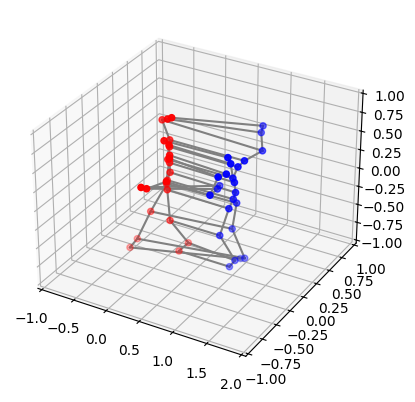

In [3]:
# Visualizing final joint skeletons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection="3d")
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Auxiliar joint poses that will be removed once we have the non-normalized pipeline
joint_poses_aux = joint_poses[42].copy()
joint_poses_aux[24:, 2] = joint_poses_aux[24:, 2] + 1

ax.scatter(joint_poses_aux[:24, 2], joint_poses_aux[:24, 0], -joint_poses_aux[:24, 1], color='red')
ax.scatter(joint_poses_aux[24:, 2], joint_poses_aux[24:, 0], -joint_poses_aux[24:, 1], color='blue')

for (start, end) in adj_matrix:
    xs = [joint_poses_aux[start, 2], joint_poses_aux[end, 2]]
    ys = [joint_poses_aux[start, 0], joint_poses_aux[end, 0]]
    zs = [-joint_poses_aux[start, 1], -joint_poses_aux[end, 1]]
    ax.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

# Bulding model

In [6]:
# Preparing dataset
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn

class graph_dataset(torch.utils.data.Dataset):
    def __init__(self, frames, edge_index):
        self.frames = frames
        self.edge_index = edge_index

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        x = torch.tensor(self.frames[idx], dtype=torch.float)
        return Data(x=x, edge_index=self.edge_index)

# Convert adjacency matrix to edge index for PyTorch Geometric
edge_index = torch.tensor(adj_matrix, dtype=torch.long).t().contiguous()

# Creating dataset
dataset = graph_dataset(joint_poses_aux, edge_index)

In [8]:
# Defining the model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class Encoder(nn.Module):
    def __init__(self, n_joints, in_dim, gnn_dim, hid_dim, lat_dim, num_layers):
        super(Encoder, self).__init__()
        self.gcn_enc = GCN(in_dim, gnn_dim, gnn_dim*2)
        vae_in_dim = n_joints * gnn_dim * 2
        self.lstm_enc = nn.LSTM(vae_in_dim, hid_dim, num_layers=num_layers, dropout=0.2, batch_first=True)
        self.hid_mean = nn.Linear(hid_dim, lat_dim)
        self.hid_logvar = nn.Linear(hid_dim, lat_dim)

    def forward(self, x):
        x = self.gcn_enc(x)
        _, (final_hid_state, _) = self.lstm_enc(x)
        mean = self.hid_mean(final_hid_state[-1])
        logvar = self.hid_logvar(final_hid_state[-1])
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, n_joints, lat_dim, hid_dim, gnn_dim, out_dim, num_layers):
        super(Decoder, self).__init__()
        self.lat_to_hid = nn.Sequential(nn.Linear(lat_dim, hid_dim), nn.ReLU())
        vae_out_dim = n_joints * gnn_dim * 2
        self.lstm_dec = nn.LSTM(hid_dim, vae_out_dim, num_layers=num_layers, dropout=0.2, batch_first=True)
        self.gcn_dec = GCN(gnn_dim*2, gnn_dim, out_dim)

    def forward(self, z, seq_len, n_joints):
        hid = self.lat_to_hid(z)
        hid = hid.unsqueeze(1).repeat(1, seq_len, 1)
        seq_outputs, _ = self.lstm_dec(hid)
        outputs = seq_outputs.squeeze(0).view(seq_len, n_joints, 3)
        return outputs

class VAE(nn.Module):
    def __init__(self, n_joints, in_dim, gnn_dim, hid_dim, lat_dim, seq_len, num_layers):
        super(VAE, self).__init__()
        self.encoder = Encoder(n_joints, in_dim, gnn_dim, hid_dim, lat_dim, num_layers)
        self.decoder = Decoder(n_joints, lat_dim, hid_dim, gnn_dim, in_dim, num_layers)
        self.seq_len = seq_len
        self.n_joints = n_joints
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = reparametrization_trick(mean, logvar).to(self.device)
        return self.decoder(z, self.seq_len, self.n_joints), mean, logvar

def reparametrization_trick(mean, logvar):
    std = torch.exp(logvar/2)
    return mean + torch.randn_like(std)*std

def loss_function(x_prime, x, mean, logvar):
    BCE = F.mse_loss(x_prime, x, reduction='sum')
    KLD = -torch.sum(1 + logvar - mean.pow(2) - logvar.exp())/2
    return BCE + 0.0001*KLD

def weight_initialization(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight)
        nn.init.constant_(model.bias, 0)
        
    elif isinstance(model, nn.LSTM):
        for param in model.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            
            else:
                nn.init.normal_(param.data)

In [ ]:
# Training process: hyperparameters selection, model instantiation and training loop
from tqdm import tqdm
import math

# Choosing hyperparameters to be the same as in the provided paper
in_dim = n_joints * 3
hid_dim = 384
lat_dim = 256
seq_len = 128
num_layers = 3
epochs = 150

# Instantiating model, moving it to device and initializing optimizer
model = VAE(in_dim, hid_dim, lat_dim, seq_len, num_layers)
model.to(device)
model.apply(weight_initialization)

optimizer = torch.optim.Adam(model.parameters())

# Training loop
best_loss = np.inf
best_model_path = 'data/best_training_model.pth'
early_stop_max = math.ceil(0.01*epochs)
early_stop_counter = 0
train_loss_series = []
val_loss_series = []
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    
    for batch_id, (dance_seq,) in enumerate(train_loader):
        optimizer.zero_grad()
        
        seq_prime, mean, logvar = model(dance_seq)
        
        loss = loss_function(seq_prime, dance_seq, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()

    avg_train_loss = train_loss/len(dancer_data)
    train_loss_series.append(avg_train_loss)
    print('Epoch: {}, Average training Loss: {}'.format(epoch, avg_train_loss))

    if epoch%5 == 0:
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for (dance_seq,) in val_loader:
                seq_prime, mean, logvar = model(dance_seq)
                loss = loss_function(seq_prime, dance_seq, mean, logvar)
                val_loss += loss.item()

        avg_val_loss = val_loss/len(val_loader)
        val_loss_series.append(avg_val_loss)
        print('Epoch: {}, Average validation Loss: {}'.format(epoch, avg_val_loss))

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            early_stop_counter = 0
            
            torch.save(model.state_dict(), best_model_path)
            print('Saved new best model with validation loss: {}'.format(best_loss))
            
        else:
            early_stop_counter += 1

    if early_stop_counter > early_stop_max:
        break